MNIST using CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
    print(f"Device name: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU.
Device name: NVIDIA GeForce RTX 3080


In [3]:
transform = transforms.ToTensor()

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../../DATA
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../../../DATA
    Split: Test
    StandardTransform
Transform: ToTensor()


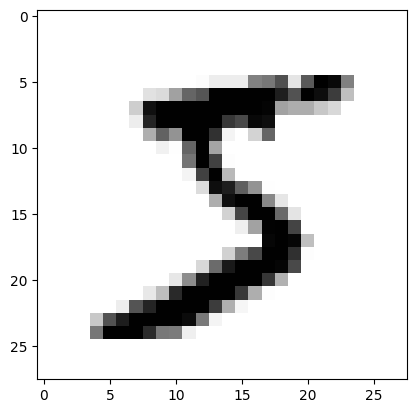

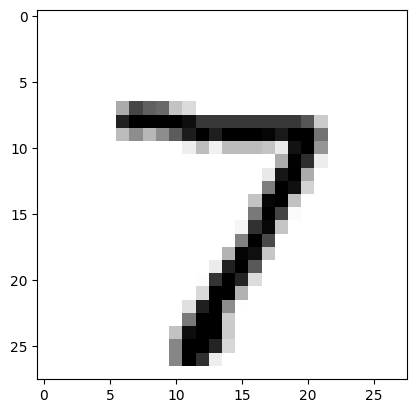

In [4]:
# Load the training and test datasets
train_data = datasets.MNIST(root='../../../../DATA', train=True, download=True, transform=transform)
print(train_data)
test_data = datasets.MNIST(root='../../../../DATA', train=False, download=True, transform=transform)
print(test_data)

# Check what the data looks like
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray_r")
plt.show()
plt.imshow(test_data[0][0].reshape((28,28)), cmap="gray_r")
plt.show()

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
conv1 = nn.Conv2d(1, 6, 3, 1) # ---> 6 filters --> pooling --> conv2
# 1 input channe(monochromatic, it will be 3 for RGB), 
# 6 output channels(feature maps/ feature extraction), 
# 3x3 kernel(how big those output images are)-(all kernals must be square aka same xy dimension), 
# stride 1

conv2 = nn.Conv2d(6, 16, 3, 1)
# 6 input channels, --> output from conv1
# 16 output channels, abertrary number - use for experimentation
# 3x3 kernel, 
# 1 stride

In [10]:
# Grab the first batch of 10 images
for i, (X_train, y_train) in enumerate(train_data):
    break

X_train.shape


torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28) # 4D batch(batch of 1 image)
# 1 image, 1 channel, 28x28 image

In [12]:
x = F.relu(conv1(x))
x.shape # 6 feature maps, 26x26 image - we lost boarder information due to kernel size - need padding but it doesnt matter for MNIST since all the images are rougly in the center

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(x, 2, 2) # 6 feature maps, 13x13 image - 2x2 pooling, stride 2
x.shape

torch.Size([1, 6, 13, 13])

In [14]:
x = F.relu(conv2(x))
x.shape # 16 feature maps, 11x11 image

torch.Size([1, 16, 11, 11])

In [15]:
x = F.max_pool2d(x, 2, 2) # 16 feature maps, 5x5 image
x.shape

torch.Size([1, 16, 5, 5])

In [16]:
(((28-2)/2-2)/2, ((28-2)/2-2)/2) # check the math

(5.5, 5.5)

In [17]:
# Flatten the data
x = x.view(-1, 16*5*5) # 16 feature maps, 5x5 image
x.shape

torch.Size([1, 400])

Part 2: Build the CNN

In [18]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1) # 6 feature maps, 5x5 image
        self.conv2 = nn.Conv2d(6, 16, 3, 1) # 16 feature maps, 5x5 image
        self.fc1 = nn.Linear(16*5*5, 120) # 16 feature maps, 5x5 image --> 120 neurons in the hidden layer
        self.fc2 = nn.Linear(120, 84) # 84 neurons in the hidden layer
        self.fc3 = nn.Linear(84, 10) # 10 classes

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5) # Flatten the data for the fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
       

In [19]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
for param in model.parameters(): # Check number of parameeter in each layer
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
import time
start_time = time.time()

epoch = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epoch):

    #TRAIN
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train) # we do not need to flatten the data here because we are using CNN
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True 1, False 0 sum() will give us the number of correct predictions
        trn_corr += batch_corr

        optimizer.zero_grad() # set the gradients to zero before backpropagation
        loss.backward() # backpropagation
        optimizer.step() # update the parameters

        if b%600 == 0:
            print(f'epoch: {i} batch: {b} loss: {loss.item()} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    #Append the loss and accuracy to the lists        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Test
    with torch.no_grad(): # we do not need gradient calculation for test
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test) # we do not need to calculate the gradients for validation
            predicted = torch.max(y_val.data, 1)[1] # get the index of the class with the highest probability
            tst_corr += (predicted == y_test).sum() # sum up the number of correct predictions
            loss = criterion(y_val, y_test)
            
    # Append the loss and accuracy to the lists
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())


current_time = time.time()
total_time = current_time - start_time
print(f'Training took {total_time/60} minutes')

epoch: 0 batch: 600 loss: 0.042550649493932724 accuracy:  78.483%
epoch: 0 batch: 1200 loss: 0.07135549932718277 accuracy:  85.825%
epoch: 0 batch: 1800 loss: 0.34511977434158325 accuracy:  88.706%
epoch: 0 batch: 2400 loss: 0.022886302322149277 accuracy:  90.479%
epoch: 0 batch: 3000 loss: 0.007212378084659576 accuracy:  91.610%
epoch: 0 batch: 3600 loss: 0.0012429531197994947 accuracy:  92.439%
epoch: 0 batch: 4200 loss: 0.5538663268089294 accuracy:  93.102%
epoch: 0 batch: 4800 loss: 0.019490700215101242 accuracy:  93.579%
epoch: 0 batch: 5400 loss: 0.011199058033525944 accuracy:  94.024%
epoch: 0 batch: 6000 loss: 0.09562695026397705 accuracy:  94.325%
epoch: 1 batch: 600 loss: 0.06711101531982422 accuracy:  97.833%
epoch: 1 batch: 1200 loss: 0.03923652321100235 accuracy:  97.833%
epoch: 1 batch: 1800 loss: 0.0033368885051459074 accuracy:  97.889%
epoch: 1 batch: 2400 loss: 0.014520023949444294 accuracy:  97.846%
epoch: 1 batch: 3000 loss: 0.18050406873226166 accuracy:  97.823%
epo

In [23]:
train_losses

[0.09562695026397705,
 0.08669640123844147,
 6.801549898227677e-05,
 0.0012924716575071216,
 0.0014367223484441638,
 0.0006410576170310378,
 0.002265332732349634,
 0.0031292629428207874,
 0.0022211377508938313,
 0.00036318443017080426]

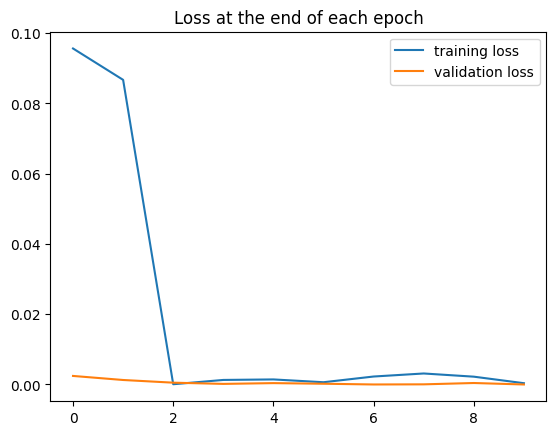

In [24]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

In [25]:
test_losses

[0.0024309384170919657,
 0.001276812399737537,
 0.0005136849940754473,
 0.00016720326675567776,
 0.0003879807482007891,
 0.0002106665342580527,
 1.1444078609201824e-06,
 4.041901775053702e-05,
 0.00041831322596408427,
 5.722037030864158e-07]

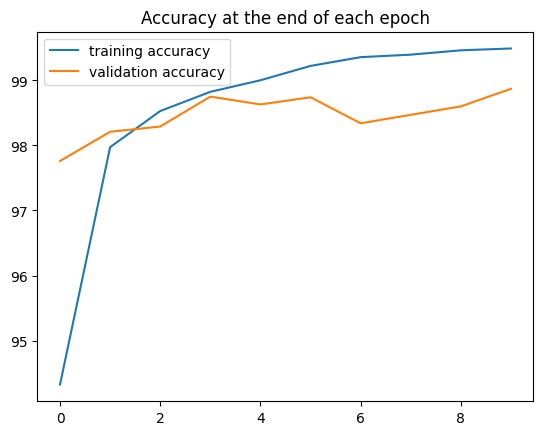

In [26]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [27]:
# Evaluate the model with the test data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        print(correct.item() / len(test_data))
        # print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

0.9887


In [29]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    2    0    0    1    3    0    2    0]
 [   1 1128    0    1    0    0    1    4    0    0]
 [   0    1 1022    3    2    0    1    5    6    1]
 [   0    1    0  995    0    6    0    0    1    1]
 [   0    0    0    0  970    0    1    0    0    2]
 [   0    2    0    4    0  884    4    0    1    7]
 [   5    1    0    1    5    1  947    0    1    0]
 [   1    2    7    4    0    0    0 1017    2    2]
 [   0    0    1    2    0    0    1    0  959    2]
 [   2    0    0    0    5    0    0    2    2  994]]


# Test for a single image

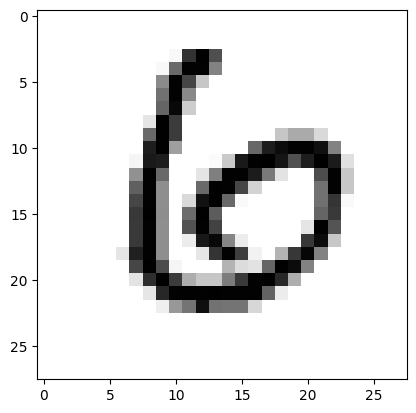

In [37]:
plt.imshow(test_data[11][0].reshape(28,28), cmap='gist_yarg')

In [36]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[11][0].view(1,1,28,28)).argmax()
    print(new_prediction.item())

6
